# Homework 5
Eric Gagliano (egagli)

## Problem 1: Correlation, Autocorrelation, Multiple Linear Regression

In this problem, you will explore the relationship between air temperature, precipitation, and snow water equivalent over time, using observations from a study site in the Washington Cascades. Download the cascades_swe.xlsx dataset for this problem.

### A. Begin by making scatterplots of each of these variables vs. all the other variables. Describe any visual patterns you see between each pair of variables.

In [1]:
# imports
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Read in a cascades swe data file
cascades_df = pd.read_excel('cascades_swe.xlsx',skiprows=8,usecols=[1,2,3,4,5])
cascades_df

,Water Year,oct-mar precip,oct-mar tmax,oct-mar tmin,April 1 SWE
0,1916,1154.570,5.03776,-5.06206,393.719
1,1917,820.952,4.56727,-6.50644,377.514
2,1918,1095.650,7.86584,-3.23471,310.131
3,1919,1041.050,5.80953,-4.22977,287.759
4,1920,817.106,5.14475,-5.36376,237.118
...,...,...,...,...,...
83,1999,1349.600,6.09335,-3.16271,440.455
84,2000,1071.650,6.92193,-2.91330,321.225
85,2001,585.318,6.24188,-3.64529,124.212
86,2002,1111.340,6.29529,-2.79578,358.346


<ipython-input-3-ede37613123c>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(cascades_df,ax=ax,color='k', marker='.', alpha=1);


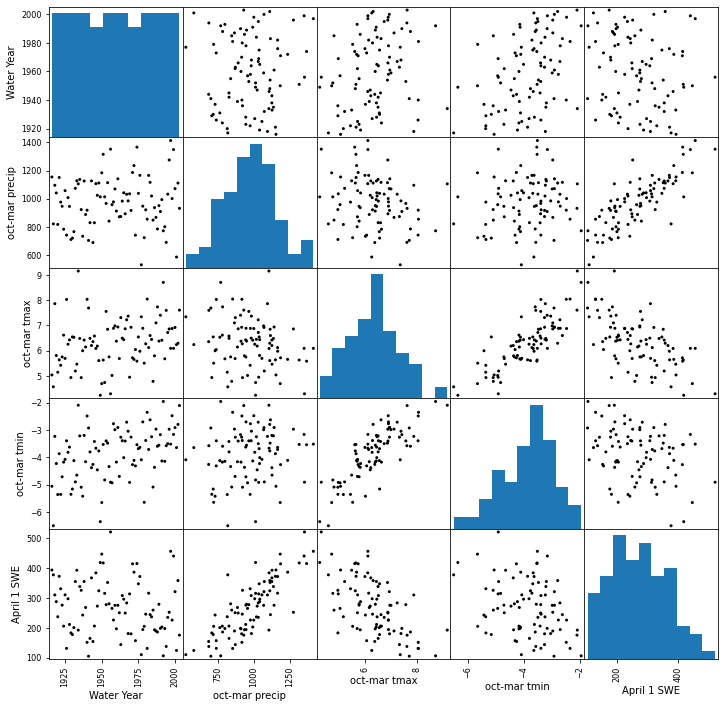

In [3]:
# plot sctterplot matrix
f,ax=plt.subplots(figsize=(12,12))
pd.plotting.scatter_matrix(cascades_df,ax=ax,color='k', marker='.', alpha=1);

Based on the scatterplot matrix, for the response variable of April 1 SWE, I see a strong positive correlation between oct-mar precipitation and April 1 SWE, a moderate negative correlation between oct-mar max temperature and April 1 SWE, and a very weak correlation between oct-mar minimum temperature and SWE. Water Year does not appear to have any correlation with April 1 SWE. For the predictor variables I see a strong positive correlation between oct-mar maximum temperature and oct-mar minimum temperature, and a weak positive correlation between Water Year and both oct-mar maximum and minimum temperatures. The rest of the variables all seem relatively not correlated.

### B. Calculate the correlation (R) between April 1 SWE and the three meteorological variables (precipitation, maximum temperature, and minimum temperature). Then also calculate R between each unique combination of the meteorological variables.

In [4]:
# use corr function to calculate r for all combinations of variables
cascades_df.corr()

,Water Year,oct-mar precip,oct-mar tmax,oct-mar tmin,April 1 SWE
Water Year,1.000000,0.054130,0.240112,0.431544,-0.160357
oct-mar precip,0.054130,1.000000,-0.234640,0.144022,0.811668
oct-mar tmax,0.240112,-0.234640,1.000000,0.815999,-0.604755
oct-mar tmin,0.431544,0.144022,0.815999,1.000000,-0.323239
April 1 SWE,-0.160357,0.811668,-0.604755,-0.323239,1.000000


### C. Calculate the autocorrelation in precipitation, maximum temperature, and minimum temperature over the timeseries. Can we consider each of these values to be an independent sample? Or do some of them depend on the prior year's sample?

**TIP:** In part C, we can test for autocorrelation at different lags, but not for any lag longer than a quarter of the length of the data series. Therefore, test for lags from 1 to N/4, where N is the length of the data series.

In [5]:
# create dataframe and loop to store autocorrelation values
autocorrs = pd.DataFrame()

for i in np.arange(1,int(len(cascades_df)/4)):
    autocorrs.loc[i,'oct-mar precip r'] = cascades_df['oct-mar precip'].autocorr(i)
    autocorrs.loc[i,'oct-mar tmax r'] = cascades_df['oct-mar tmax'].autocorr(i)
    autocorrs.loc[i,'oct-mar tmin r'] = cascades_df['oct-mar tmin'].autocorr(i)

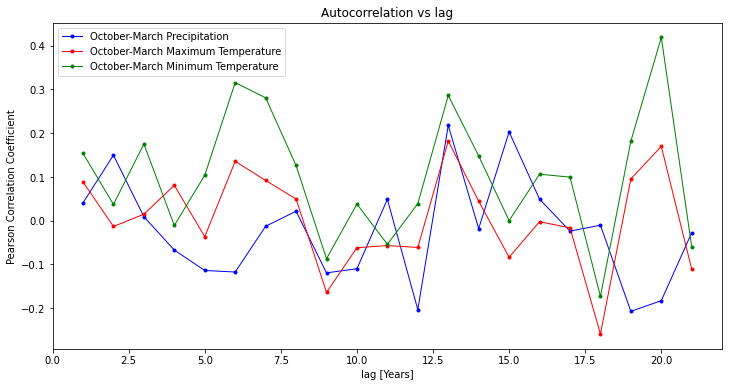

In [6]:
# plot correlations
f,ax=plt.subplots(figsize=(12,6))
autocorrs['oct-mar precip r'].plot(ax=ax,c='b', linestyle='-', linewidth=1, marker='.', label='October-March Precipitation')
autocorrs['oct-mar tmax r'].plot(ax=ax,c='r', linestyle='-', linewidth=1, marker='.', label='October-March Maximum Temperature')
autocorrs['oct-mar tmin r'].plot(ax=ax,c='g', linestyle='-', linewidth=1, marker='.', label='October-March Minimum Temperature')
ax.set_title('Autocorrelation vs lag')
ax.set_xlabel('lag [Years]')
ax.set_ylabel('Pearson Correlation Coefficient')
ax.legend()

We can consider these values to be an independent sample because a year's precipitation and temperature shouldn't be dependent on previous year's precipitation and temperatures. This is evident in the autocorrelation plot where there is little lag autocorrelation. We do notice some slight periodicity / autocorrelation at lags of 6 years and 20 years. This could be due to larger scale cycles such as ENSO or PDO as mentioned by Jessica on slack. 

### D. Fit a multiple linear regression model to the data, using all three meteorological variables (precipitation, maximum temperature, and minimum temperature) to predict April 1 SWE. Report the trend in each meteorological variable. Estimate the overall trend in SWE, and trend due to each meteorological variable alone. How much of the overall trend is due to the combined effects of trends in both maximum and minimum temperature?

**TIP:** In part D we want to quantify how much a change in each variable accounts for a change in SWE. We start with making a multiple linear regression model, such as one which looks like:

$SWE = B_0 + B_1*precip + B_2*t_{max} + B_3*t_{min}$

We then have values for all regression parameters (each B value). Take the derivative of both sides with respect to time. Our regression parameter values are coefficients in this new equation.

$\frac{d(SWE)}{dt}= B_1\frac{d(precip)}{dt} + B_2\frac{d(t_{max})}{dt} + B_3\frac{d(t_{min})}{dt}$

Then to find how much the trend in SWE is accounted for by the trend in precipitation we compute $B_1\frac{d(precip)}{dt}$ where $\frac{d(precip)}{dt}$ in the slope of the trend in precipitation.

In [7]:
# fit multiple linear regression model to the data
predictors = np.append(np.ones_like([cascades_df['April 1 SWE']]).T,cascades_df.iloc[:,1:4].to_numpy(),axis=1)
B,_,_,_ = scipy.linalg.lstsq(predictors, cascades_df.iloc[:,4])
cascades_df['SWE prediction'] = predictors.dot(B)
props = pd.DataFrame(predictors*B,columns=['April 1 SWE','oct-mar precip','oct-mar tmax','oct-mar tmin'])
props['abs_total'] = props.abs().sum(axis=1)
props['percent_temp'] = 100*((np.abs(props['oct-mar tmax']) + np.abs(props['oct-mar tmin']))/props['abs_total'])

In [8]:
# calculate derivatives of variables
variables = pd.concat([cascades_df.iloc[:,1:4],cascades_df.iloc[:,4]],axis=1)
derivs = variables.diff()
derivs['Water Year'] = cascades_df['Water Year']
derivs = derivs.set_index('Water Year')

Text(0, 0.5, 'Percent')

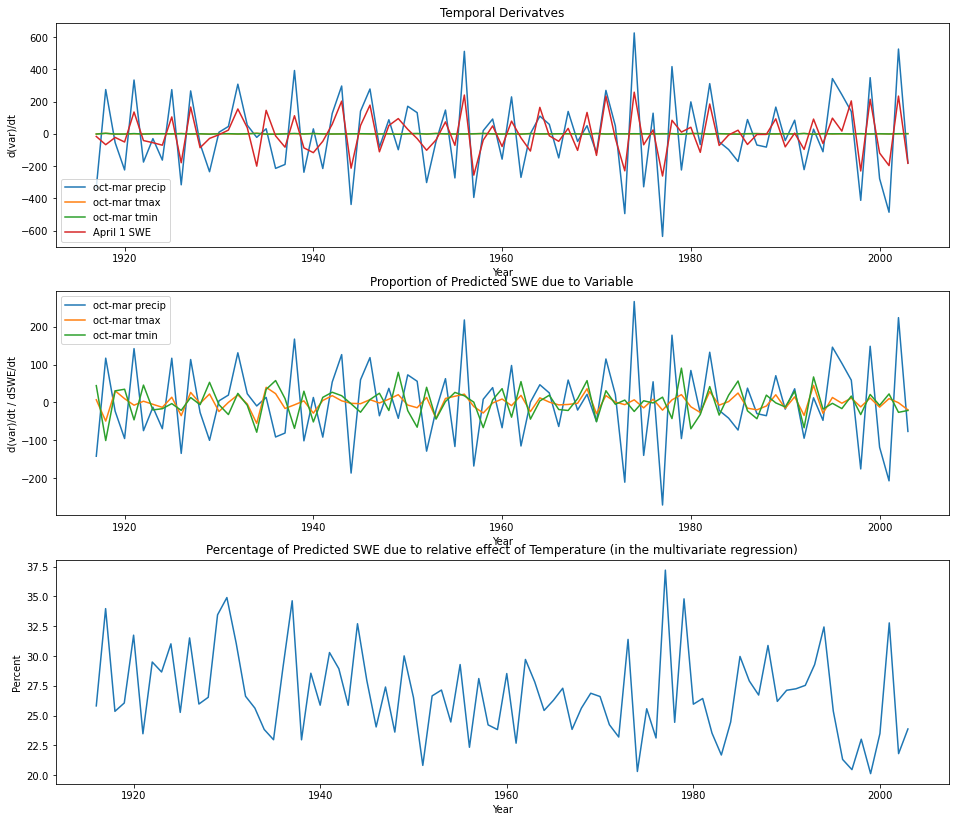

In [9]:
# plot derivatives and proportion of predicted SWE
f,ax=plt.subplots(3,1,figsize=(16,14))
derivs.plot(ax=ax[0])
ax[0].set_title('Temporal Derivatves')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('d(var)/dt')
ax[0].legend()
Bs = np.concatenate([B[1:4],[1]])
Bs
dprops = derivs*Bs
dprops['oct-mar precip'].plot(ax=ax[1])
dprops['oct-mar tmax'].plot(ax=ax[1])
dprops['oct-mar tmin'].plot(ax=ax[1])
ax[1].set_title('Proportion of Predicted SWE due to Variable')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('d(var)/dt / dSWE/dt')
ax[1].legend()

ax[2].plot(cascades_df['Water Year'],props['percent_temp'])
ax[2].set_title('Percentage of Predicted SWE due to relative effect of Temperature (in the multivariate regression)')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Percent')

In [10]:
# simple linear regressions
B1_precip, B0_precip, r, p, sB1 = stats.linregress(cascades_df.iloc[:,1],cascades_df.iloc[:,4])
B1_tmax, B0_tmax, r, p, sB1 = stats.linregress(cascades_df.iloc[:,2],cascades_df.iloc[:,4])
B1_tmin, B0_tmin, r, p, sB1 = stats.linregress(cascades_df.iloc[:,3],cascades_df.iloc[:,4])
precip = B1_precip*cascades_df.iloc[:,1] + B0_precip
tmax = B1_tmax*cascades_df.iloc[:,2] + B0_tmax
#tmin = B1_tmin*cascades_df.iloc[:,3] + B0_tmin

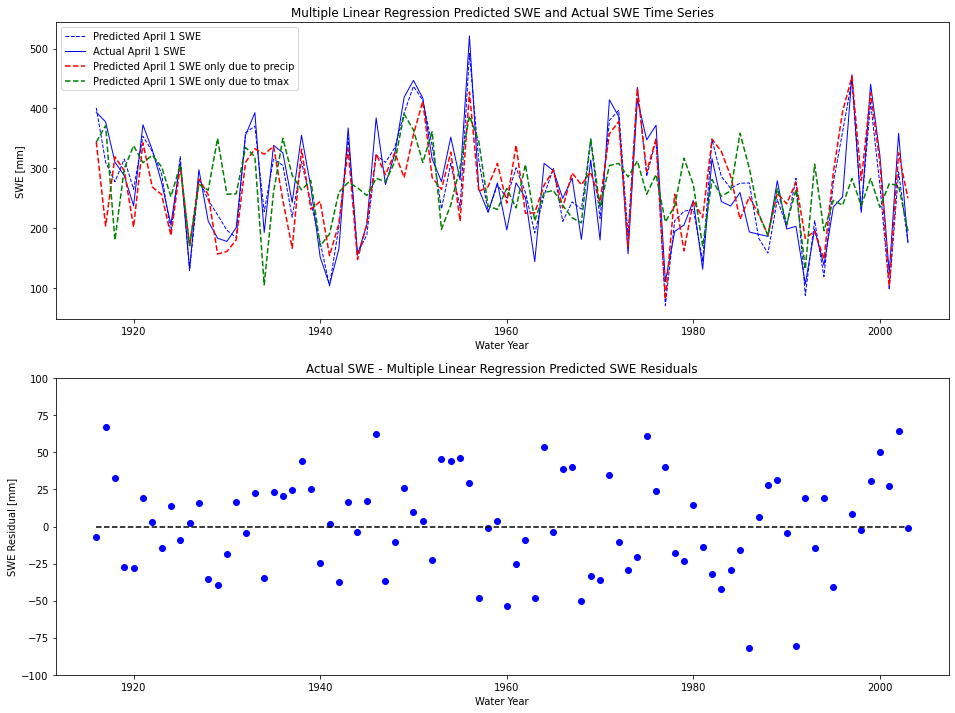

In [11]:
# plot predicted and actual SWE
f,ax=plt.subplots(2,1,figsize=(16,12))
cascades_df.plot(x='Water Year',y='SWE prediction',c='b', linestyle='--', linewidth=1, ax=ax[0], label='Predicted April 1 SWE')
cascades_df.plot(x='Water Year',y='April 1 SWE',c='b', linestyle='-', linewidth=1, ax=ax[0], label='Actual April 1 SWE')
ax[0].plot(cascades_df['Water Year'],precip, linestyle='--', color='r',label='Predicted April 1 SWE only due to precip')
ax[0].plot(cascades_df['Water Year'],tmax, linestyle='--', color='g',label='Predicted April 1 SWE only due to tmax')
#ax[0].plot(cascades_df['Water Year'],tmin, linestyle='--', label='Predicted SWE due to tmin')

ax[1].scatter(cascades_df['Water Year'],cascades_df['April 1 SWE']-cascades_df['SWE prediction'],color='b')
ax[1].hlines(0,cascades_df['Water Year'].min(),cascades_df['Water Year'].max(),linestyle='--',color='k')
ax[0].set_title('Multiple Linear Regression Predicted SWE and Actual SWE Time Series')
ax[0].set_xlabel('Water Year')
ax[0].set_ylabel('SWE [mm]')
ax[0].legend()
ax[1].set_title('Actual SWE - Multiple Linear Regression Predicted SWE Residuals')
ax[1].set_xlabel('Water Year')
ax[1].set_ylabel('SWE Residual [mm]')
ax[1].set_ylim([-100,100]);

In [12]:
print(f'The regression parameters are...')
print(f'B0: {B[0]:.4}')
print(f'B1: {B[1]:.4}')
print(f'B2: {B[2]:.4}')
print(f'B3: {B[3]:.4}')

The regression parameters are...
B0: -171.8
B1: 0.4262
B2: -14.94
B3: -30.78


Based on our known parameters for the equation $SWE = B_0 + B_1*precip + B_2*t_{max} + B_3*t_{min}$, we know for every additional 1mm of October-March precipitation we would expect a 0.4262mm increase in SWE. For every 1 additional degree of celsius of the October-March temperature maximum we would expect a 14.94mm decrease in SWE. Finally, for every 1 additional degree of celsius increase of the October-March temperature minimum we would expect a 30.78mm decrease in SWE.

# References

Note: A large amount of this code is adapted from the CEWA 565 course materials, predominantly from the lab 5 jupyter notebook which can be found in module 5 of the class website: https://mountain-hydrology-research-group.github.io/data-analysis/modules/module5.html